In [1]:
%load_ext Cython

In [2]:
%%cython

import numpy as np
cimport numpy as np
import cython

# Code

In [3]:
# %%cython
# # %%cython --annotate
# import numpy as np
# cimport numpy as np
# import cython


def simple_map_prepare(nCh, nPix):
    """
    Prepare a simple map.
    
    Parameters
    ----------
    nCh: int
        Number of channels
    nPix: int
        Number of pixels
    
    Returns
    -------
    signal_map: ndarray
        an array of length nCh, where each entry is a length-nPix zero array.
    hits_map: ndarray
        same as above with dtype int32
    """
    signal_map = np.zeros((nCh, nPix))
    hits_map = np.zeros((nCh, nPix), dtype=np.int32)
    return signal_map, hits_map

In [4]:
# %%cython
# # %%cython --annotate
# import numpy as np
# cimport numpy as np
# import cython

# simple_map_python


def simple_map(signal_map, hits_map, pointing, mask, array):
    # debug
#     print(signal_map, hits_map, pointing, mask, array)

    nCh, nt = array.shape
    nPix = signal_map.shape[1]

    for i in range(nCh):
        for j in range(nt):
            if mask[i, j]:
                signal_map[i, pointing[j]] += array[i, j]
                hits_map[i, pointing[j]] += 1
    ok = hits_map > 0
    signal_map[ok] /= hits_map[ok]

    # debug
#     print(signal_map, hits_map, pointing, mask, array)

In [5]:
# %%cython
# # %%cython --annotate
# import numpy as np
# cimport numpy as np
# import cython

# simple_scan_subtract_python


def simple_scan_subtract(signal_map, pointing, array):
    nCh, nt = array.shape
    nPix = signal_map.shape[1]
    for i in range(nCh):
        for j in range(nt):
            array[i, j] -= signal_map[i, pointing[j]]

In [6]:
# %%cython
# # %%cython --annotate
# import numpy as np
# cimport numpy as np
# import cython

def get_pointing(az, az_min, az_range, nPix):
    """
    Parameters
    ----------
    az: ndarray
        The azimuth of the timestream.
    az_min: float
        The minimum of az
    az_range: float
        maximum minus minimum of az
    nPix: int
        no. of pixels
    Returns
    -------
    pointing: ndarray
        for each elements in az, the corresponding elements in pointing
        is the n-th number of pixel it is at.
    """
    pointing = np.int_(np.floor(nPix * (az - az_min) / az_range))
    # One point with az = az_max will end up one bin too far left
    pointing[pointing == nPix] = nPix - 1
    return pointing

In [7]:
def ground_template_filter_array(
        input_array,
        az,
        mask,
        pixel_size,
        groundmap=False,
        lr=False,
        filtmask=None):
    '''
    Remove ground template from array timestreams

    Parameters
    ----------
    input_array: array_like
        shape: (number of channels, number of time steps)
        Input timestream, mutated inplace.
    az: array_like
        shape: input_array[0]
        The azimuth of the timestream.
    mask: array_like
        shape: input_array
        dtype: bool
    pixel_size: float
    groundmap: bool
        If groundmap = True, then do the exact opposite,
        and remove component from timestream that isn't fixed with the ground
    lr: bool
        If true, ground substraction done separately on left and right moving scans
    filtmask: array_like
        shape: input_array
        dtype: bool
        filtmask means to compute the filter template with that subset of the data,
        operation is applied to data specified by mask
        In largepatch filtmask refers to wafermask_chan_filt
    '''
    # initialize
    nCh, nTime = input_array.shape
    az_min = np.min(az)
    az_max = np.max(az)
    az_range = az_max - az_min
    if filtmask is None:
        filtmask = mask

    assert input_array.shape == mask.shape == filtmask.shape
    assert az.size == nTime

    # Calculate number of pixels given the pixel size
    nPix = int(np.round(az_range / pixel_size))
    assert nPix > 3
    # recalculate pixel_size (because nPix is int)
    pixel_size = az_range / nPix

    # bin at nPix is used as a junk pixel
    signal_map, hits_map = simple_map_prepare(nCh, nPix + 1)
    pointing = get_pointing(az, az_min, az_range, nPix)

    if groundmap:
        array_in = input_array.copy()

    if lr:
        vaz = np.gradient(az)
        # select left / right moving timestream
        l = vaz >= 0
        r = vaz < 0
        pointingL = pointing.copy()
        pointingL[~l] = nPix
        pointingR = pointing.copy()
        pointingR[~r] = nPix

        simple_map(signal_map, hits_map, pointingL, filtmask, input_array)
        signal_map[:, nPix] = 0
        simple_scan_subtract(signal_map, pointingL, input_array)
        signal_map[:] = 0
        hits_map[:] = 0
        simple_map(signal_map, hits_map, pointingR, filtmask, input_array)
        signal_map[:, nPix] = 0
        simple_scan_subtract(signal_map, pointingR, input_array)
    else:
        simple_map(signal_map, hits_map, pointing, filtmask, input_array)
        simple_scan_subtract(signal_map, pointing, input_array)

    if groundmap:
        input_array[:, :] = array_in - input_array

# Tests

In [8]:
import numpy as np
from numpy.testing import assert_allclose

def assertIdenticalList(list1, list2):
    for i, list1i in enumerate(list1):
        if isinstance(list1i, bool):
            assert list1i is list2[i]
        else:
            assert_allclose(list1i, list2[i], rtol=1e-03)

In [9]:
import pickle
import sys
py2 = sys.version_info[0] == 2


def test_ground_template_filter_array():
    with open('tests/timestream/ground_template_filter_array_input.pkl', 'rb') as f:
        if not py2:
            ground_template_filter_array_input = pickle.load(
                f, encoding='latin1')
        else:
            ground_template_filter_array_input = pickle.load(f)
    with open('tests/timestream/ground_template_filter_array_output.pkl', 'rb') as f:
        if not py2:
            ground_template_filter_array_output = pickle.load(
                f, encoding='latin1')
        else:
            ground_template_filter_array_output = pickle.load(f)
    ground_template_filter_array(*ground_template_filter_array_input)
    assertIdenticalList(
        ground_template_filter_array_input,
        ground_template_filter_array_output)

    # debug
    return ground_template_filter_array_input, ground_template_filter_array_output

# Playground

In [10]:
with open('tests/timestream/ground_template_filter_array_input.pkl', 'rb') as f:
    ground_template_filter_array_input = pickle.load(f, encoding='latin1')
with open('tests/timestream/ground_template_filter_array_output.pkl', 'rb') as f:
    ground_template_filter_array_output = pickle.load(f, encoding='latin1')

In [11]:
for i in ground_template_filter_array_input:
    print(type(i), i)

<class 'numpy.ndarray'> [[ 0.00239068  0.00086831  0.00415364 ..., -0.00705077  0.00699701
  -0.01150024]]
<class 'numpy.ndarray'> [ 3.53594566  3.53711146  3.53820095 ...,  3.64341665  3.64234824
  3.64129303]
<class 'numpy.ndarray'> [[ True  True  True ...,  True  True  True]]
<class 'float'> 0.0013962634015954637
<class 'bool'> False
<class 'bool'> False
<class 'numpy.ndarray'> [[ True  True  True ...,  True  True  True]]


In [12]:
for i in ground_template_filter_array_output:
    print(type(i), i)

<class 'numpy.ndarray'> [[ 0.          0.0032052   0.00404837 ..., -0.0070533   0.00699448
  -0.01087422]]
<class 'numpy.ndarray'> [ 3.53594566  3.53711146  3.53820095 ...,  3.64341665  3.64234824
  3.64129303]
<class 'numpy.ndarray'> [[ True  True  True ...,  True  True  True]]
<class 'numpy.float64'> 0.00139568480121
<class 'bool'> False
<class 'bool'> False
<class 'numpy.ndarray'> [[ True  True  True ...,  True  True  True]]


In [13]:
for i, __ in enumerate(ground_template_filter_array_input):
    print(np.array_equal(ground_template_filter_array_input[i], ground_template_filter_array_output[i]))

False
True
True
False
True
True
True


In [14]:
for i in ground_template_filter_array_input:
    if type(i) == np.ndarray:
        print(i.dtype)

float64
float64
bool
bool


In [15]:
input_array, az, mask, pixel_size, groundmap, lr, filtmask = ground_template_filter_array_input

In [16]:
input_array

array([[ 0.00239068,  0.00086831,  0.00415364, ..., -0.00705077,
         0.00699701, -0.01150024]])

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

# Input plot

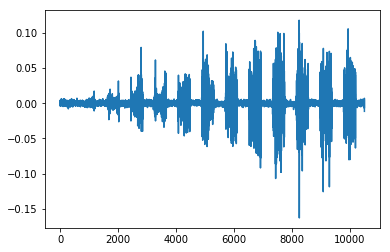

In [18]:
plt.plot(input_array[0])

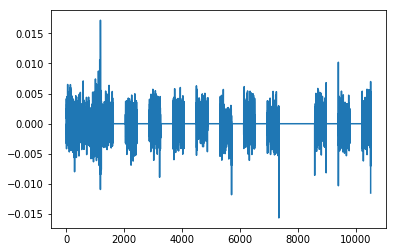

In [19]:
plt.plot(input_array[0] * mask[0])

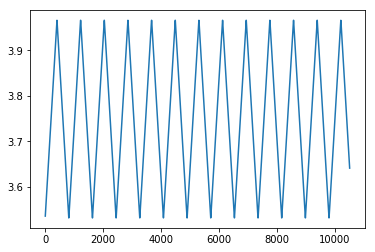

In [20]:
plt.plot(az)

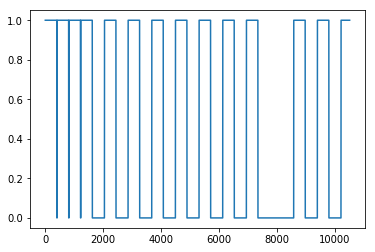

In [21]:
plt.plot(mask[0])

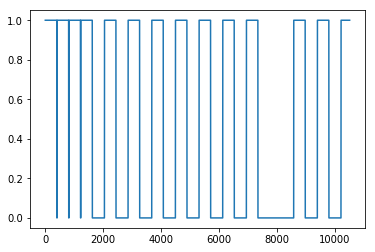

In [22]:
plt.plot(filtmask[0])

In [23]:
np.array_equal(mask[0], filtmask[0])

True

# Output

In [27]:
%%timeit
output_array = input_array.copy()
ground_template_filter_array(output_array, az, mask, pixel_size)

10 loops, best of 3: 21.5 ms per loop


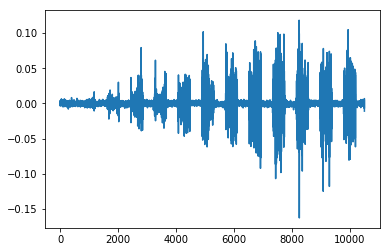

In [25]:
plt.plot(output_array[0])

In [26]:
test_ground_template_filter_array()

((array([[ 0.        ,  0.0032052 ,  0.00404837, ..., -0.0070533 ,
           0.00699448, -0.01087422]]),
  array([ 3.53594566,  3.53711146,  3.53820095, ...,  3.64341665,
          3.64234824,  3.64129303]),
  array([[ True,  True,  True, ...,  True,  True,  True]], dtype=bool),
  0.0013962634015954637,
  False,
  False,
  array([[ True,  True,  True, ...,  True,  True,  True]], dtype=bool)),
 (array([[ 0.        ,  0.0032052 ,  0.00404837, ..., -0.0070533 ,
           0.00699448, -0.01087422]]),
  array([ 3.53594566,  3.53711146,  3.53820095, ...,  3.64341665,
          3.64234824,  3.64129303]),
  array([[ True,  True,  True, ...,  True,  True,  True]], dtype=bool),
  0.0013956848012076121,
  False,
  False,
  array([[ True,  True,  True, ...,  True,  True,  True]], dtype=bool)))